# Visualization of ghg emission x words
Ref: https://github.com/Data-Science-Public-Policy/graspp_2025_spring/blob/main/notebooks/module_4/week_9/transformer_spacy_scrape.ipynb

In [1]:
import pandas as pd

In [2]:
ghg_df = pd.read_csv("../data/processed/edgar_ghg_emission_processed.csv")
ghg_df.head()

,Unnamed: 0,Country,Year,Emission (MtCO2eq/yr)
0,0,GLOBAL TOTAL,2014-01-01,48930.176837
1,1,GLOBAL TOTAL,2015-01-01,48808.767176
2,2,GLOBAL TOTAL,2016-01-01,49058.441256
3,3,GLOBAL TOTAL,2017-01-01,49878.733809
4,4,GLOBAL TOTAL,2018-01-01,51026.627449


# 2.1 Counting words

In [3]:
import pandas as pd
# IF previous 2.A doesn't work
file_name = "../data/processed/manifesto_english_speaking.parquet"
df_all = pd.read_parquet(file_name)
df_all.reset_index().countryname.unique()

array(['Australia', 'Canada', 'Ireland', 'South Africa', 'United Kingdom',
       'United States'], dtype=object)

### 2.1.1 Create count function

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# Count!
count_array = vectorizer.fit_transform(
                        df_all['text'] # INPUT THE TEXT COLUMN TO THE WORD COUNTER "vectorizer"
        ).toarray()

type(count_array) #Matrix with the counts but not yet a data frame

numpy.ndarray

### 2.1.2 Make the count function into a dataframe

In [5]:
df_wordcount = pd.DataFrame(
    count_array, # Data above will become the values of the dataframe
    columns=vectorizer.get_feature_names_out(), # Words will become the column names
    index = df_all.index # Index country date comes from the df_all dataframe
)
df_wordcount.head(2)

00  000  0000  00025  00061  0007  000american  000gw  \
countryname date                                                                
Australia   1961-12-01   0    1     0      0      0     0            0      0   
            1961-12-01   0    0     0      0      0     0            0      0   

                        000ha  000km  ...  ﬂourishes  ﬂourishing  ﬂow  ﬂowing  \
countryname date                      ...                                       
Australia   1961-12-01      0      0  ...          0           0    0       0   
            1961-12-01      0      0  ...          0           0    0       0   

                        ﬂows  ﬂuctuations  ﬂuorescent  ﬂy  \
countryname date                                            
Australia   1961-12-01     0            0           0   0   
            1961-12-01     0            0           0   0   

                        ﬂyerhouseholdresilienceprogram  ﬂying  
countryname date                                               
Australia   1961-12-01                               0      0  
            1961-12-01                               0      0  

[2 rows x 61137 columns]

### 2.1.3 Show most common words

In [6]:
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10)

,most_common
the,330494
and,230602
to,209002
of,180444
in,118888
for,83003
will,81298
we,69737
that,51160
our,45675


## 2.2 Count n-grams (more than one word combinations)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
# Now we can get fancier with the count vectorizer by counting more than one word combinations and remove stop words
vectorizer = CountVectorizer(
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (3,3),

)
# Count!
count_array = vectorizer.fit_transform(df_all['text']).toarray()
df_wordcount = pd.DataFrame(
    count_array, # Data above will become the values of the dataframe
    columns=vectorizer.get_feature_names_out(), # Words will become the column names
    index = df_all.index # Index country date comes from the df_all dataframe
)
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10)

,most_common
le bloc québécois,2140
elected coalition government,1164
le gouvernement fédéral,949
shorten labor government,674
que le gouvernement,424
liberal nationals government,405
aboriginal torres strait,339
elected morrison government,338
coalition government continue,329
du gouvernement fédéral,327


<Axes: >

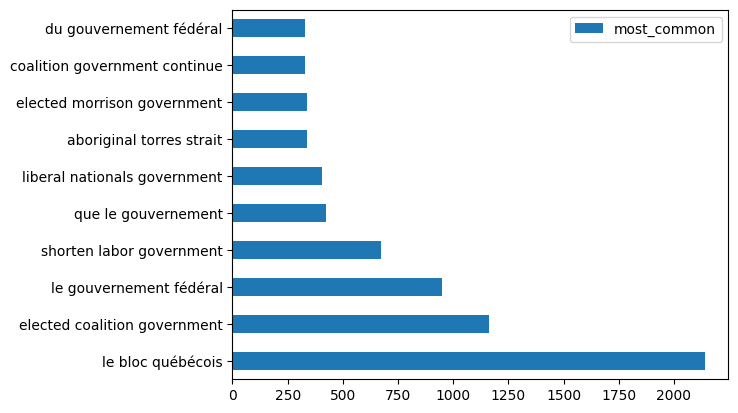

In [8]:
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10).plot(kind = 'barh')

## 2.3 Visualizing word count in dataframe

In [9]:
vectorizer = CountVectorizer(
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (1,3),
    min_df = .1

)
counts = vectorizer.fit_transform(df_all['text']).toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))

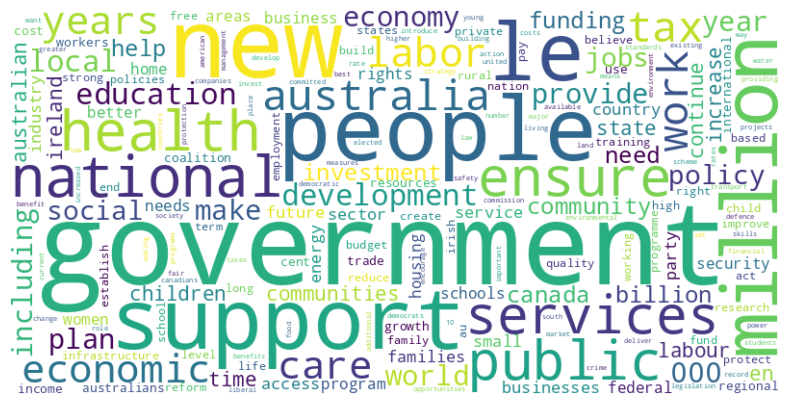

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.4 Make into a function

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_country_wordcloud(country_name, df, ax=None, save_path=None):
    country_df = df.query(f"countryname == '{country_name}'")
    vectorizer = CountVectorizer(
        analyzer='word',
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 3),
        min_df=0.1
    )

    counts = vectorizer.fit_transform(country_df['text']).toarray().sum(axis=0)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))

    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)

    if ax:
        ax.imshow(wordcloud)
        ax.axis('off')
        ax.set_title(f"Word Cloud for {country_name}", size=20)
    else:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title(f"Word Cloud for {country_name}", size=20)

    if save_path:
        plt.savefig(save_path)

### 2.4.1 One example

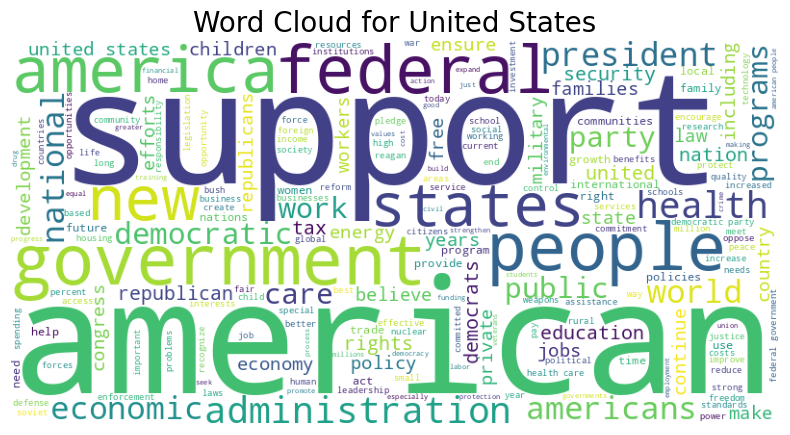

In [12]:
#fig, axes = plt.subplots(figsize=(12, 10))

generate_country_wordcloud(
    country_name = 'United States',
    df = df_all,
    #ax = axes
)

### 2.4.2 Multiple

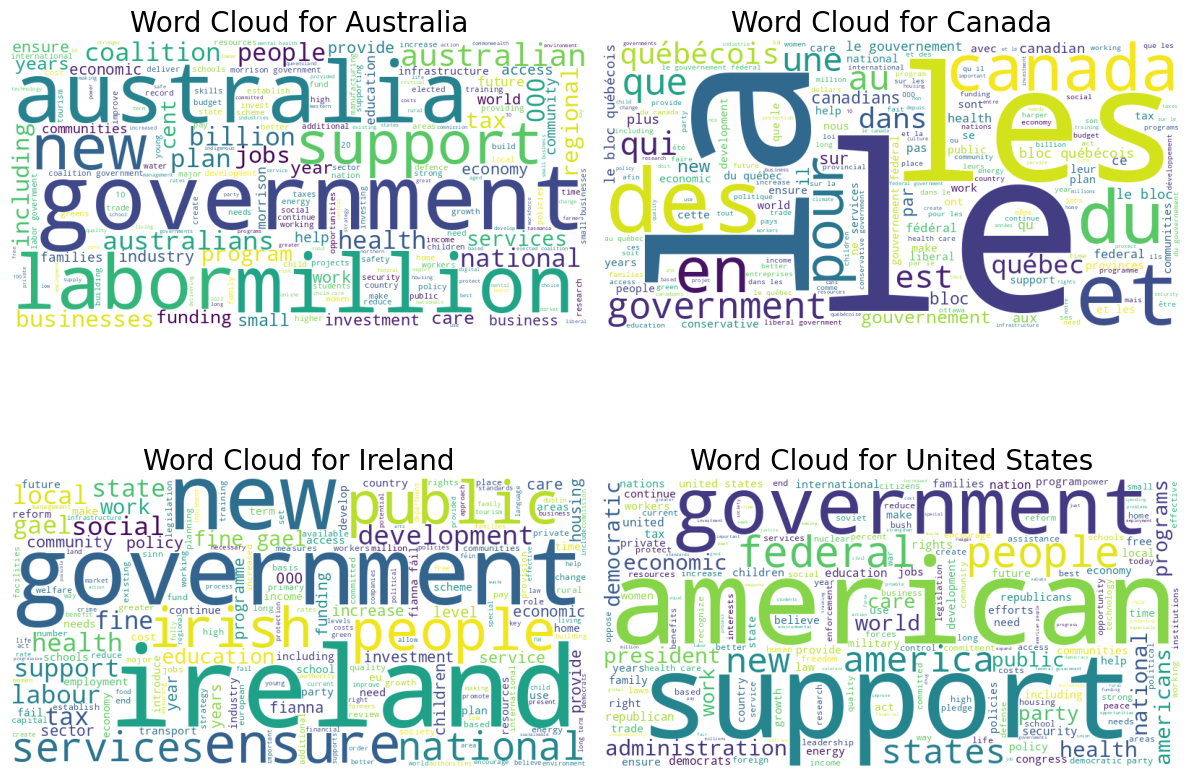

In [13]:
countries_to_plot = ['Australia', 'Canada', 'Ireland', 'United States'] # A sample of 4 countries for a 2x2 grid

# 3. Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes to easily iterate through them
for i, country in enumerate(countries_to_plot):
    generate_country_wordcloud(
        country, df_all, axes[i] # Run function for all
                              )
plt.tight_layout()


## 2.5 Count words across time

### 2.5.1 Count by country

In [14]:
vocab_list = ['environment', 'emissions']
vectorizer = CountVectorizer(
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (1,1),
    vocabulary = vocab_list

)
counts = vectorizer.fit_transform(df_all['text']).toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))
word_freq

{'environment': np.int64(3250), 'emissions': np.int64(1485)}

### 2.5.2 Count by year and date

In [15]:
# add year column
df_all = df_all.reset_index().assign(year = lambda column: column['date'].dt.year)
df_all.head(2)

,countryname,date,party,partyname,keys,manifesto_id,text,year
0,Australia,1961-12-01,63320,Australian Labor Party,63320_196112,63320_196112,Labour government would subsidise interest rat...,1961
1,Australia,1961-12-01,63330,Democratic Labor Party,63330_196112,63330_196112,New concepts needed for Nation’s problems. Me...,1961


In [16]:
word_freq_by_country = {}
for country_name, country_df in df_all.groupby(['countryname', 'year']):
    vectorizer = CountVectorizer(
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 1),
        vocabulary=vocab_list
    )
    counts = vectorizer.fit_transform(country_df['text']).toarray().sum(axis=0)
    word_freq_by_country[country_name] = dict(zip(vectorizer.get_feature_names_out(), counts))
df_timeseries = pd.DataFrame(word_freq_by_country).transpose()
df_timeseries.head(2)

environment  emissions
Australia 1961            0          0
          1963            0          0

#### Convert to Long

In [45]:
df_long = df_timeseries.stack().to_frame('count').reset_index()
df_long.head(3)

,level_0,level_1,level_2,count
0,Australia,1961,environment,0
1,Australia,1961,emissions,0
2,Australia,1963,environment,0


In [46]:
df_long = df_long.rename({"level_0": 'country', 'level_1':'year', 'level_2': 'vocab'}, axis='columns')
df_long.head(2)

,country,year,vocab,count
0,Australia,1961,environment,0
1,Australia,1961,emissions,0


#### Plot

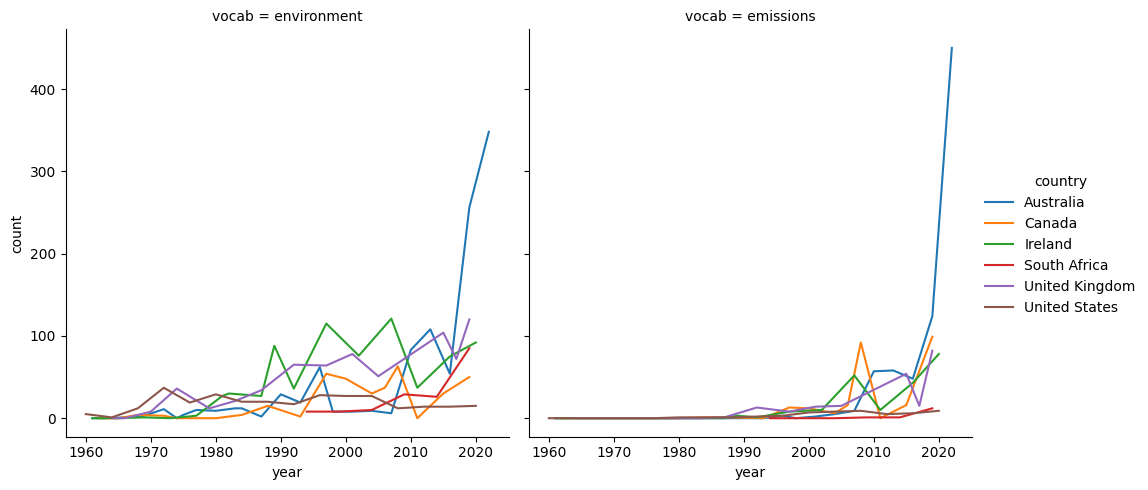

In [47]:
import seaborn as sns
sns.relplot(
    data=df_long, x="year", y="count", hue="country", col="vocab", kind="line"
)

# 3. Spacy & Transformers

## 3.1 Spacy

In [20]:
df_all.tail(2)

,countryname,date,party,partyname,keys,manifesto_id,text,year
379,United States,2020-11-01,61320,Democratic Party,61320_202011,61320_202011,2020 Democratic Party Platform The platform wa...,2020
380,United States,2020-11-01,61620,Republican Party,61620_202011,61620_202011,"Preamble With this platform, we the Republican...",2020


### 3.1.1 Part of speech

In [23]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp('Labour government would subsidise interest rates for housing to encourage home-building.')
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Labour labour ADJ JJ amod Xxxxx True False
government government NOUN NN nsubj xxxx True False
would would AUX MD aux xxxx True True
subsidise subsidise VERB VB ROOT xxxx True False
interest interest NOUN NN compound xxxx True False
rates rate NOUN NNS dobj xxxx True False
for for ADP IN prep xxx True True
housing housing NOUN NN pobj xxxx True False
to to PART TO aux xx True True
encourage encourage VERB VB advcl xxxx True False
home home NOUN NN compound xxxx True False
- - PUNCT HYPH punct - False False
building building NOUN NN dobj xxxx True False
. . PUNCT . punct . False False


### 3.1.2 Entity extraction

In [24]:
doc = nlp("Preamble With this platform, we the Republican Party reaffirm the principles that unite us in a common purpose. We believe in American exceptionalism. We believe the United States of America is unlike any other nation on earth.")
for ent in doc.ents:
    print(ent.text, ent.label_)

the Republican Party ORG
American NORP
the United States of America GPE


### 3.1.3 Pipeline

In [25]:
from tqdm import tqdm
import spacy

# Define keywords
KEYWORDS = ["emissions", "greenhouse"]

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Prepare data
df_nlp = df_all.tail(10)
all_text = df_nlp['text'].to_list()

# Process text
pipe = nlp.pipe(all_text,
                disable=['ner', 'entity_linker', 'textcat', 'textcat_multilabel'],
                # n_process=8,
                # batch_size=10
               )

# Initialize key sentences list
key_sentences = []

# Iterate over processed documents
for doc in tqdm(pipe):
    # Initialize list to store key sentences for the current document
    key_sentences_inonedocument = []

    # Iterate over sentences in the document
    for sentence in doc.sents:
        # Check if any keyword is present in the sentence
        if any(keyword.lower() in sentence.text.lower() for keyword in KEYWORDS):
            # Append the sentence to the list if a keyword is found
            key_sentences_inonedocument.append(sentence.text)

    # Append the list of key sentences for the current document to the main list
    key_sentences.append(key_sentences_inonedocument)

df_nlp['environment_sentences'] = key_sentences
df_nlp.head(2)

10it [00:53,  5.36s/it]
/var/folders/_c/dp9t7r814wnfbyyhsn8wtdv40000gn/T/ipykernel_8343/2198416095.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['environment_sentences'] = key_sentences


,countryname,date,party,partyname,keys,manifesto_id,text,year,environment_sentences
371,United States,2004-11-01,61320,Democratic Party,61320_200411,61320_200411,PREAMBLE As we come together to declare our vi...,2004,"[We will reduce mercury emissions, smog and ac..."
372,United States,2004-11-01,61620,Republican Party,61620_200411,61620_200411,INTRODUCTION AND PREAMBLE One hundred and fift...,2004,"[For instance, working with Congressional Repu..."


## 3.2 Transformers

### 3.2.A Example
### Use uv pip install torch in Apple silicon Mac, since uv add does not work
### There is Torch installation issue

In [73]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Downloading model may take a few minutes the first time (2.24GB to download)
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2024-1-1")
#model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-context-2024-1-1", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [ ]:
# Define the sentence to be processed for sentiment analysis or classification
sentence = "We will restore funding to the Global Environment Facility and the Intergovernmental Panel on Climate Change, to support critical climate science research around the world"

# Tokenize the input sentence using the tokenizer associated with the model
inputs = tokenizer(sentence,
                   return_tensors="pt", # Returns pytorch tensors
                   max_length=200,
                   padding="max_length",
                   truncation=True)

# Pass the tokenized inputs through the model to obtain the logits (raw prediction scores)
logits = model(**inputs).logits

# Apply softmax to the logits to convert them into probabilities
probabilities = torch.softmax(logits, dim=1).tolist()[0]

# Create a dictionary mapping each class label to its corresponding probability, rounded to two decimal places
probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}

# Sort the dictionary by probability values in descending order
probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))

# Determine the predicted class by finding the index of the maximum logit value and mapping it to the corresponding label
predicted_class = model.config.id2label[logits.argmax().item()]

top_probabilities = {category:probability for category, probability in probabilities.items() if probability>10}
top_probabilities

{'501 - Environmental Protection: Positive': 67.56,
 '411 - Technology and Infrastructure': 14.03,
 '107 - Internationalism: Positive': 13.58}

### 3.2.1 Apply to our earlier example

#### Function

In [ ]:
def get_top_probabilities(sentence,  label_probability_threshold=10):
    # Tokenize the input sentence
    inputs = tokenizer(sentence,
                       return_tensors="pt",  # Returns pytorch tensors
                       max_length=200,
                       padding="max_length",
                       truncation=True)
    # Pass the tokenized inputs through the model to obtain the logits
    with torch.no_grad():
        logits = model(**inputs).logits
    # Apply softmax to the logits to convert them into probabilities
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    # Create a dictionary mapping each class label to its corresponding probability, rounded to two decimal places
    probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}
    # Sort the dictionary by probability values in descending order
    probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
    # Filter probabilities above the threshold
    top_probabilities = {category: probability for category, probability in probabilities.items() if probability > label_probability_threshold}
    return [label.split(" - ")[1] for label in list(top_probabilities.keys())] # Label only

# Example usage
sentence = "We will restore funding to the Global Environment Facility and the Intergovernmental Panel on Climate Change, to support critical climate science research around the world"
top_probs = get_top_probabilities(sentence, label_probability_threshold = 10)
print(top_probs)

['Environmental Protection: Positive', 'Technology and Infrastructure', 'Internationalism: Positive']


#### For loop

In [ ]:
from tqdm import tqdm

transformer_sentiment = []

for row in tqdm(df_nlp['environment_sentences'].to_list()):
    sentences = []
    for sentence in row:
        predicted_labels = get_top_probabilities(sentence, label_probability_threshold=20)
        sentences.append(predicted_labels)
    transformer_sentiment.append(sentences)

100%|██████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


In [ ]:
df_nlp['transformer_labels'] = transformer_sentiment
df_nlp.head(2)

/var/folders/k9/3kvg9l4d0sz7kr8v4sdn4y_40000gn/T/ipykernel_61691/3366530066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['transformer_labels'] = transformer_sentiment


,countryname,date,party,partyname,keys,manifesto_id,text,year,environment_sentences,transformer_labels
371,United States,2004-11-01,61320,Democratic Party,61320_200411,61320_200411,PREAMBLE As we come together to declare our vi...,2004,"[We will reduce mercury emissions, smog and ac...","[[Environmental Protection: Positive], [Enviro..."
372,United States,2004-11-01,61620,Republican Party,61620_200411,61620_200411,INTRODUCTION AND PREAMBLE One hundred and fift...,2004,"[For instance, working with Congressional Repu...","[[Anti-Growth Economy: Positive, Environmental..."


#### Count number of labels for each year, country, partyname

In [ ]:
index_cols = ['countryname', 'date', 'partyname']
df_label_counts = df_nlp.set_index(index_cols)['transformer_labels'].explode().explode().groupby(index_cols).value_counts().to_frame().reset_index()
df_label_counts.head(3)

,countryname,date,partyname,transformer_labels,count
0,United States,2004-11-01,Democratic Party,Environmental Protection: Positive,2
1,United States,2004-11-01,Democratic Party,National Way of Life: Positive,1
2,United States,2004-11-01,Republican Party,Anti-Growth Economy: Positive,4


#### Graph

/var/folders/k9/3kvg9l4d0sz7kr8v4sdn4y_40000gn/T/ipykernel_61691/316758905.py:5: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(ax=axes[0], data=df_label_counts.query("partyname == 'Democratic Party'").sort_values('transformer_labels'),
/var/folders/k9/3kvg9l4d0sz7kr8v4sdn4y_40000gn/T/ipykernel_61691/316758905.py:13: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(ax=axes[1], data=df_label_counts.query("partyname == 'Republican Party'").sort_values('transformer_labels'),


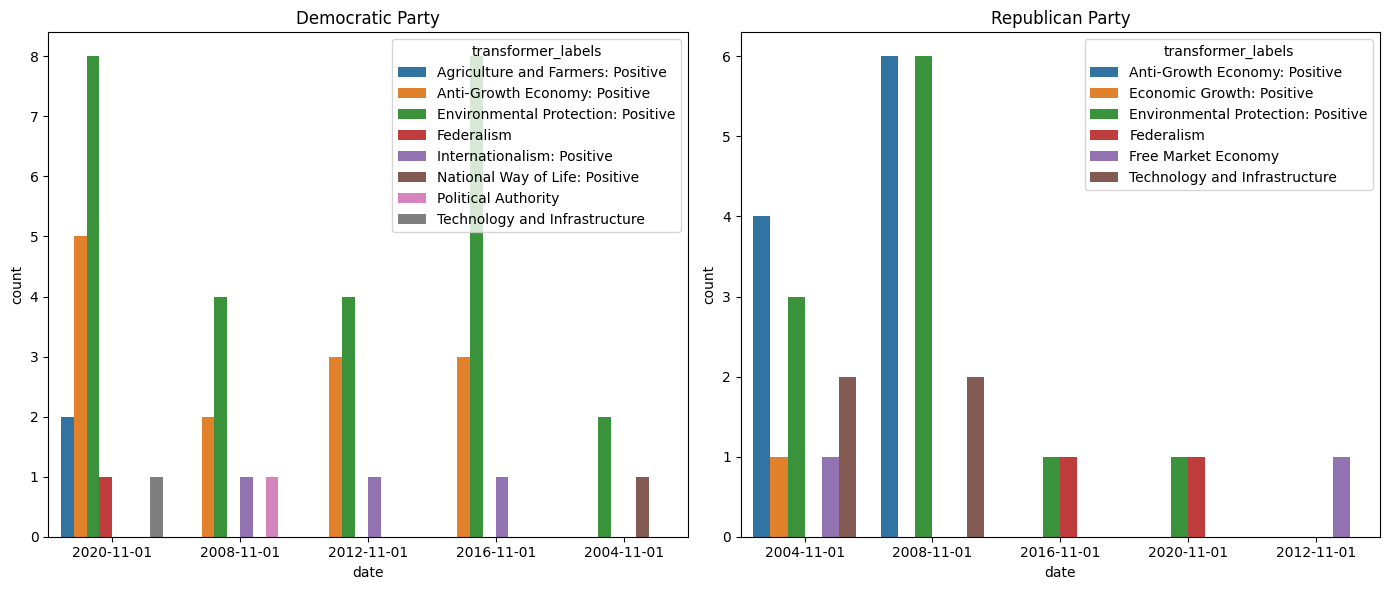

In [ ]:
# **Explicitly pass the palette to each barplot**
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Democratic Party plot
sns.barplot(ax=axes[0], data=df_label_counts.query("partyname == 'Democratic Party'").sort_values('transformer_labels'),
            x='date', y='count', hue='transformer_labels', palette=palette

           )

axes[0].set_title('Democratic Party')

# Republican Party plot
sns.barplot(ax=axes[1], data=df_label_counts.query("partyname == 'Republican Party'").sort_values('transformer_labels'),
            x='date', y='count', hue='transformer_labels', palette=palette)

axes[1].set_title('Republican Party')

plt.tight_layout()
plt.show()

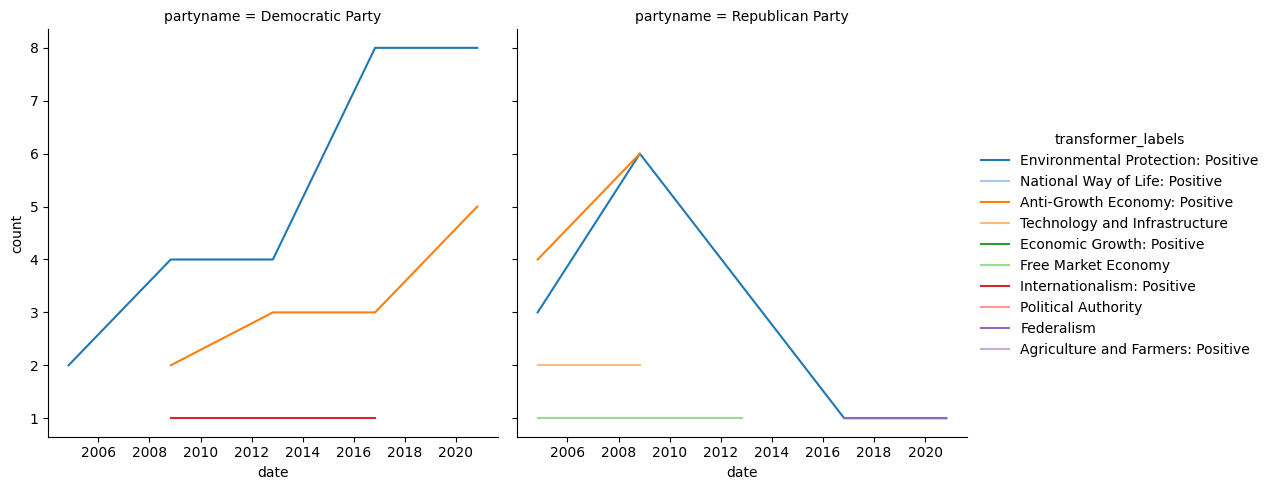

In [ ]:
sns.relplot(
    data=df_label_counts, x='date', y='count', hue='transformer_labels', col="partyname",
    kind="line"
)

# 4. Visualization of GHG x Word count

## 4.1 Use df_long and ghg data

In [71]:
df_long_viz = df_long.groupby(["country", "year"]).sum().drop("vocab", axis=1).reset_index()
df_long_viz.head()
df_long[df_long["country"] == "Canada"]

,country,year,vocab,count
48,Canada,1962,environment,0
49,Canada,1962,emissions,0
50,Canada,1963,environment,0
51,Canada,1963,emissions,0
52,Canada,1965,environment,0
53,Canada,1965,emissions,0
54,Canada,1968,environment,4
55,Canada,1968,emissions,0
56,Canada,1972,environment,3
57,Canada,1972,emissions,0


In [62]:
ghg_df_viz = ghg_df.copy()
ghg_df_viz["Year"] = ghg_df_viz["Year"].str.slice(start=0, stop=4).astype("int32")

In [64]:
df_viz = df_long_viz.merge(ghg_df_viz, left_on=["country", "year"], right_on=["Country", "Year"])

In [66]:
df_viz

,country,year_x,count,Unnamed: 0,Country,Year,Emission (MtCO2eq/yr),year_y
0,Canada,2015,46,111,Canada,2015,755.905719,NaN
1,Canada,2019,149,115,Canada,2019,788.007679,NaN
2,United States,2016,20,22,United States,2016,6206.284817,NaN
3,United States,2020,24,26,United States,2020,5671.604437,NaN


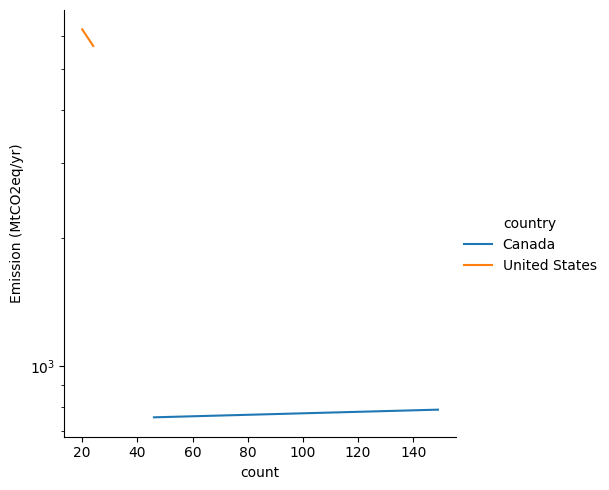

In [70]:
g = sns.relplot(
    data=df_viz, x='count', y='Emission (MtCO2eq/yr)', hue='country',
    kind="line"
)
g.set(yscale="log")

Since the word counts are available in limited years (2 yrs for each country), the visualization does not mean so much.
Need to use df_label, beyond word counts

## 4.2 Use df_label and ghg data